In [41]:
import pandas as pd
from datetime import datetime, timedelta
from dateutil import parser
import random
import utilities
import os
from scipy.stats import gaussian_kde
import numpy as np
import pytz
from collections import Counter
import math

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [18]:
from scipy import stats

In [19]:
reload(utilities)

<module 'utilities' from 'utilities.pyc'>

In [20]:
metas = utilities.loadmetadata()

In [21]:
r = next(metas.iterrows())[40]

IndexError: tuple index out of range

In [120]:
r = metas.iloc[40]

In [121]:
events, tweets = utilities.fullgame(r)

In [47]:
lenhalf = 20*60
amonth, aday = tweets['time'].iloc[0].month, tweets['time'].iloc[0].day
startgame = list(events[(events['Seconds'] == 0)]['WallClockTime'])[0]
endgame = list(events[(events['Seconds'] == 0)]['WallClockTime'])[-1]

startgame = startgame.replace(month = amonth, day = aday)
endgame = endgame.replace(month = amonth, day = aday)

lengame = (endgame - startgame).seconds
halfbegin = startgame + timedelta(seconds = lengame/2 - lenhalf/2)
halfend = startgame + timedelta(seconds = lengame/2 + lenhalf/2)

filt_tweets = tweets[(tweets['time'] <= halfbegin) | (tweets['time'] >= halfend)]

In [104]:
events.index = events['WallClockTime']

In [78]:
tweetf = tweets['sentnum'].groupby([tweets.index.hour, tweets.index.minute]).mean().to_frame()
eventf = events['Margin'].groupby([events.index.hour, events.index.minute]).mean().to_frame()
eventf['count'] = events['Margin'].groupby([events.index.hour, events.index.minute]).count().to_frame()

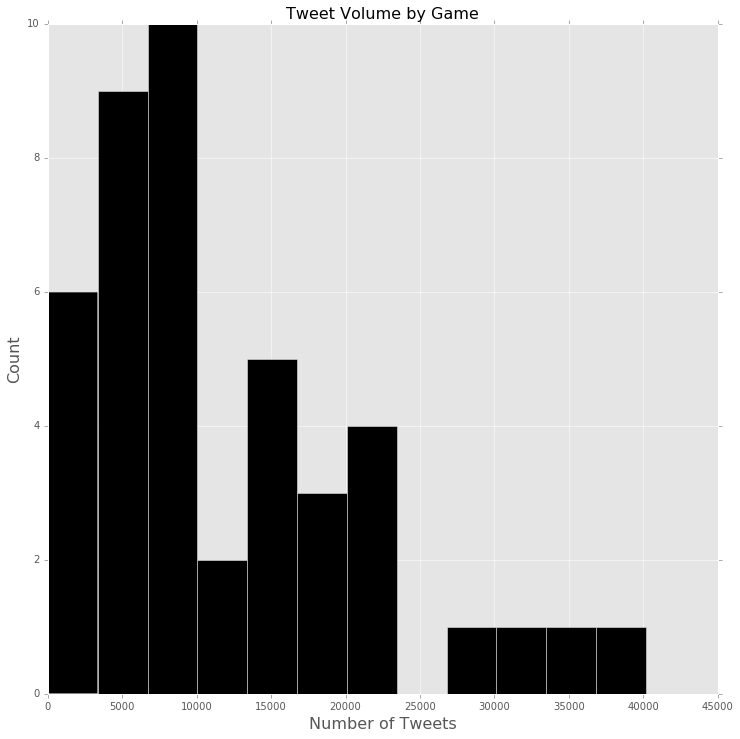

In [108]:
# Figure 3 generated 
files = os.listdir("../separated")
cleanfiles = [x for x in files if '_clean' in x]

gamedict = {}
for item in cleanfiles:
    df = pd.read_csv(item)
    gamedict[item.split("_clean")[0]] = len(df['time'])

agd = gamedict
agd['UNCVillanova'] = 0
fig = plt.figure(figsize=(12,12))
plt.hist(agd.values(), bins=12, color = 'black')
plt.title('Tweet Volume by Game', fontsize = 16)
plt.xlabel('Number of Tweets', fontsize = 16)
plt.ylabel('Count', fontsize = 16)  

In [165]:
# Write a simple function that converts the datetime to a "%H:%M" variable
def simpleconv(datetime):
    return str(datetime.hour) + ":" + str(datetime.minute)

def getgamemeta(gp1, gp2):
    gmdat = pd.read_csv("GameMetadata.csv")
    metadat = gmdat[((gmdat['Team1'] == gp1) | (gmdat['Team1'] == gp2)) & ((gmdat['Team2'] == gp1) | (gmdat['Team2'] == gp2))]
    eid = int(metadat['espn_id'].iloc[0])
    begin, end = datetime.strptime(metadat['Start'].iloc[0], '%H:%M'), datetime.strptime(metadat['End'].iloc[0], '%H:%M')
    lenhalf = 20*60
    htbegin = begin + timedelta(0, (end-begin).seconds/2 - lenhalf/2)
    htend = begin + timedelta(0,(end-begin).seconds/2 + lenhalf/2)
    
    return {'meta': metadat,
            'start': begin,
            'end': end,
            'htstart':htbegin, 
            'htend': htend} 

In [192]:
endid

Int64Index([72], dtype='int64')

In [253]:
# Figure 4 generated
r = metas.iloc[40]
events, tweets = utilities.fullgame(r)

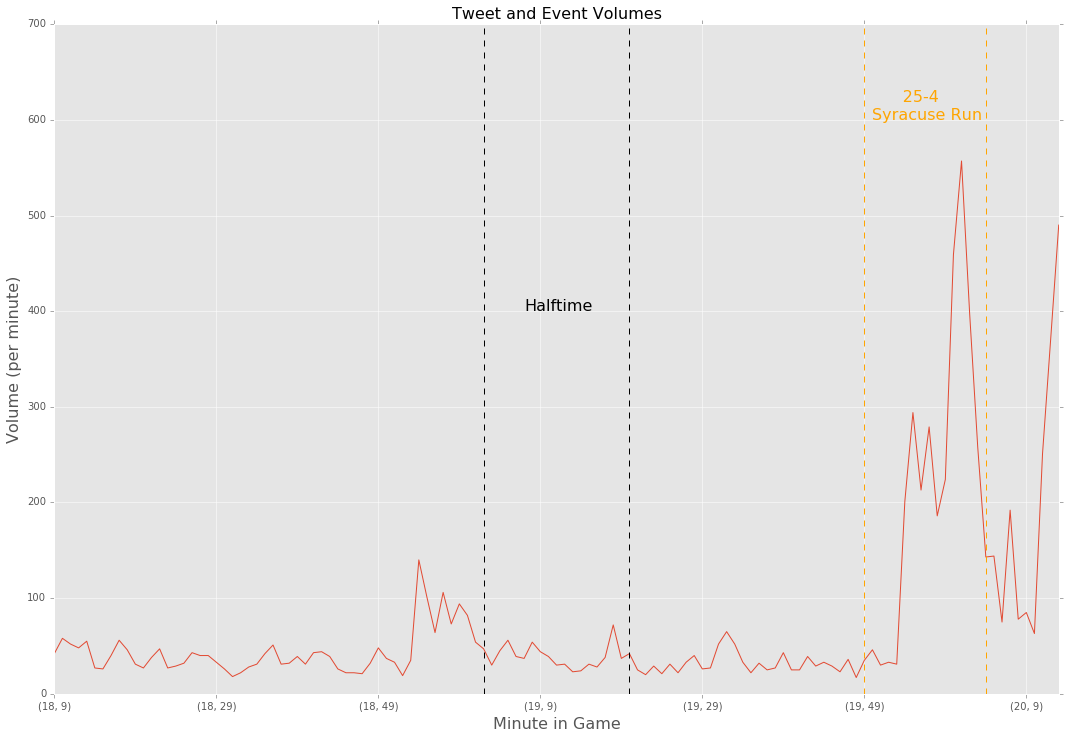

In [251]:
gamemeta = getgamemeta('Syracuse', 'Virginia')

td = tweets
td['time'] = td['time'].astype(str)
td.index = td['time'].map(lambda x : parser.parse(x) - timedelta(hours=4))
tweetsdf = td['time_chg'].groupby([td.index.hour,td.index.minute]).count().to_frame() # /twtotal
tweetsdf.columns = [['count']] #'MarginChange']] 
plt.figure(figsize = (18,12))
tweetsdf['count'].plot()

# run a basic regression
tweetsdf = tweetsdf.reset_index()
beginhour, beginminute = simpleconv(gamemeta['htstart']).split(':')
endhour, endminute = simpleconv(gamemeta['htend']).split(':')
tweetsdf[['level_0', 'level_1']] = tweetsdf[['level_0', 'level_1']].astype(str)
begid = tweetsdf[(tweetsdf['level_0'] == beginhour) & (tweetsdf['level_1'] == beginminute)].index
endid = tweetsdf[(tweetsdf['level_0'] == endhour) & (tweetsdf['level_1'] == endminute)].index
midid = tweetsdf[(tweetsdf['level_0'] == str(19)) & (tweetsdf['level_1'] == str(54))].index

plt.title('Tweet and Event Volumes', fontsize = 16)
plt.xlabel("Minute in Game", fontsize = 16)
plt.ylabel('Volume (per minute)', fontsize = 16)
plt.axvline(x=begid+1, color = 'black', ls='dashed')
plt.axvline(x=endid-1, color = 'black', ls='dashed')
plt.ylim((0,700))
plt.annotate('Halftime', xy=(((begid+endid)/2)[0]-4,str(400)), fontsize = 16)

# Numbers calculated manually from looking at box score
plt.axvline(x=100, color = 'orange', ls='dashed')
plt.axvline(x=115, color = 'orange', ls='dashed')
plt.annotate('      25-4 \nSyracuse Run', xy=((midid)[0]-4,str(600)), fontsize = 16, color = 'orange')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


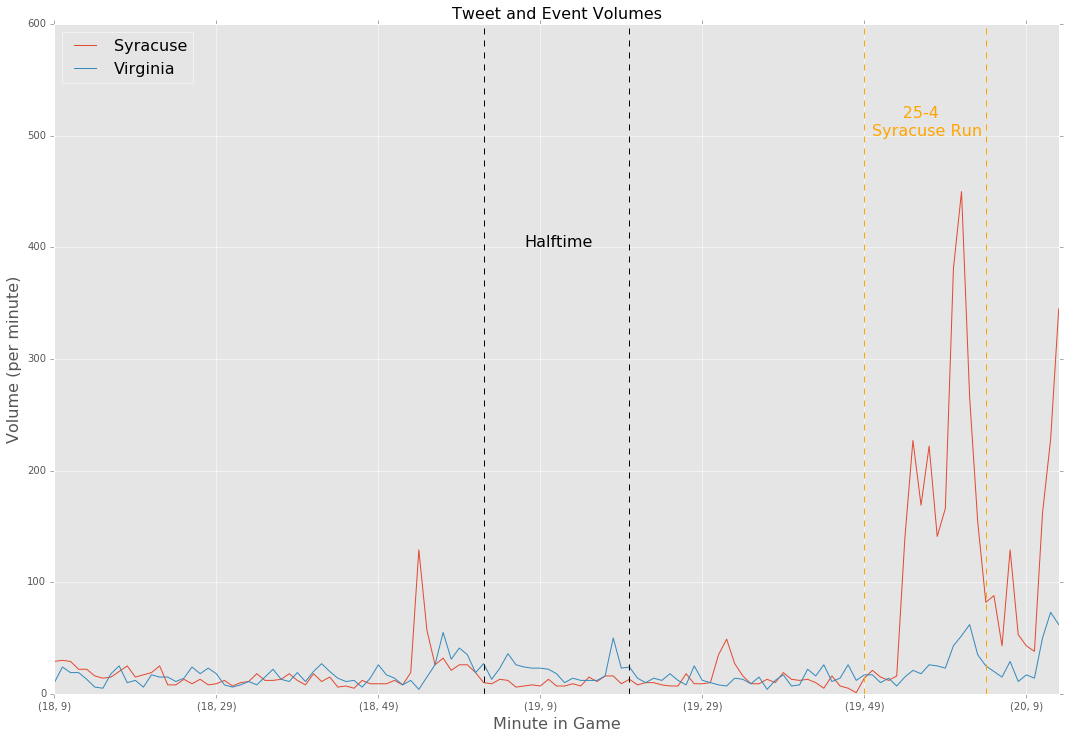

In [254]:
# Figure 5 generated
cuse = tweets[(tweets['Team1Indc'] == 1) & (tweets['Team2Indc'] == 0)].reset_index()
uva = tweets[(tweets['Team1Indc'] == 0) & (tweets['Team2Indc'] == 1)]
both = tweets[(tweets['Team1Indc'] == 1) & (tweets['Team2Indc'] == 1)]
neither = tweets[(tweets['Team1Indc'] == 0) & (tweets['Team2Indc'] == 0)]

cuse['time'] = cuse['time'].astype(str)
cuse.index = cuse['time'].map(lambda x : parser.parse(x) - timedelta(hours=4))
cusedf = cuse['time_chg'].groupby([cuse.index.hour,cuse.index.minute]).count().to_frame() # /twtotal
cusedf.columns = [['count']] #'MarginChange']] 

uva['time'] = uva['time'].astype(str)
uva.index = uva['time'].map(lambda x : parser.parse(x) - timedelta(hours=4))
uvadf = uva['time_chg'].groupby([uva.index.hour,uva.index.minute]).count().to_frame() # /twtotal
uvadf.columns = [['count']] #'MarginChange']] 

# run a basic regression
cusedf = cusedf.reset_index()
beginhour, beginminute = simpleconv(gamemeta['htstart']).split(':')
endhour, endminute = simpleconv(gamemeta['htend']).split(':')
cusedf[['level_0', 'level_1']] = cusedf[['level_0', 'level_1']].astype(str)
begid = cusedf[(cusedf['level_0'] == beginhour) & (cusedf['level_1'] == beginminute)].index
endid = cusedf[(cusedf['level_0'] == endhour) & (cusedf['level_1'] == endminute)].index
midid = tweetsdf[(tweetsdf['level_0'] == str(19)) & (tweetsdf['level_1'] == str(54))].index

plt.figure(figsize = (18,12))
cusedf['count'].plot()
uvadf['count'].plot()
plt.title('Tweet and Event Volumes', fontsize = 16)
plt.xlabel("Minute in Game", fontsize = 16)
plt.ylabel('Volume (per minute)', fontsize = 16)
plt.axvline(x=begid+1, color = 'black', ls='dashed')
plt.axvline(x=endid-1, color = 'black', ls='dashed')
plt.ylim((0,600))
plt.annotate('Halftime', xy=(((begid+endid)/2)[0]-4,str(400)), fontsize = 16)
plt.legend(['Syracuse', 'Virginia'], loc = 2, fontsize = 16)
plt.axvline(x=100, color = 'orange', ls='dashed')
plt.axvline(x=115, color = 'orange', ls='dashed')
plt.annotate('      25-4 \nSyracuse Run', xy=((midid)[0]-4,str(500)), fontsize = 16, color = 'orange')

In [14]:
# Figure 6
r = metas.iloc[40]
events, tweets = utilities.fullgame(r)

utilities.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dt2['time'] = tweets['time'].map(lambda t : parser.parse(t).replace(tzinfo=None))


ValueError: Wrong number of items passed 0, placement implies 1

In [6]:
def sentcount(x):
    count = []
    for item in range(0, len(x)):
        subset = x[0:item]
        count.append(subset.count('positive') - 2*subset.count('negative'))
    return count

cuse = tweets[(tweets['Team1Indc'] == 1) & (tweets['Team2Indc'] == 0)].reset_index()
uva = tweets[(tweets['Team1Indc'] == 0) & (tweets['Team2Indc'] == 1)]

cuse['sentcount'] = sentcount(list(cuse['sentiment']))
uva['sentcount'] = sentcount(list(uva['sentiment']))

cuse['time'] = cuse['time'].astype(str)
cuse.index = cuse['time'].map(lambda x : parser.parse(x) - timedelta(hours=4))
cusedf = cuse['time_chg'].groupby([cuse.index.hour,cuse.index.minute]).count().to_frame() # /twtotal
cusedf.columns = [['count']] 

plt.figure(figsize = (18,12))
# cusedf['count'].plot(color = 'white')

cusedf = cusedf.reset_index()

cuse['hour'] = cuse.index.hour
cuse['minute'] = cuse.index.minute
cuse['hour_minute'] = cuse['hour']*100 + cuse['minute']

cuserelvsentcount = []
for val in cuse['hour_minute'].unique():
    hour, minute = int(str(val)[0:2]), int(str(val)[2:4])
    sent = np.max(cuse[(cuse['hour'] == hour) & (cuse['minute'] == minute)]['sentcount'])
    cuserelvsentcount.append(sent)
cusedf['SyracuseSent'] = cuserelvsentcount 

uva['time'] = uva['time'].astype(str)
uva.index = uva['time'].map(lambda x : parser.parse(x) - timedelta(hours=4))
uvadf = uva['time_chg'].groupby([uva.index.hour,uva.index.minute]).count().to_frame() # /twtotal
uvadf.columns = [['count']] 
uvadf = uvadf.reset_index()

uva['hour'] = uva.index.hour
uva['minute'] = uva.index.minute
uva['hour_minute'] = uva['hour']*100 + uva['minute']

uvarelvsentcount = []
for val in uva['hour_minute'].unique():
    hour, minute = int(str(val)[0:2]), int(str(val)[2:4])
    sent = np.max(uva[(uva['hour'] == hour) & (uva['minute'] == minute)]['sentcount'])
    uvarelvsentcount.append(sent)
uvadf['UVASent'] = uvarelvsentcount 

xdff = cusedf.groupby(['level_0', 'level_1']).mean()

xdff['SyracuseSent'].plot()
uvadf['UVASent'].plot()
plt.title('Tweet Sentiment By Minute', fontsize = 16)
plt.xlabel("Minute in Game", fontsize = 16)
plt.ylabel('Aggregate Sentiment', fontsize = 16)

beginhour, beginminute = simpleconv(gamemeta['htstart']).split(':')
endhour, endminute = simpleconv(gamemeta['htend']).split(':')
cusedf[['level_0', 'level_1']] = cusedf[['level_0', 'level_1']].astype(str)
begid = cusedf[(cusedf['level_0'] == beginhour) & (cusedf['level_1'] == beginminute)].index
endid = cusedf[(cusedf['level_0'] == endhour) & (cusedf['level_1'] == endminute)].index
midid = cusedf[(cusedf['level_0'] == str(19)) & (cusedf['level_1'] == str(54))].index

plt.axvline(x=begid+1, color = 'black', ls='dashed')
plt.axvline(x=endid-1, color = 'black', ls='dashed')
plt.annotate('Halftime', xy=(((begid+endid)/2)[0]-4,str(400)), fontsize = 16)
plt.legend(['Syracuse', 'Virginia'], loc = 2, fontsize = 16)
plt.axvline(x=100, color = 'orange', ls='dashed')
plt.axvline(x=115, color = 'orange', ls='dashed')
plt.annotate('      25-4 \nSyracuse Run', xy=((midid)[0]-4,str(900)), fontsize = 16, color = 'orange')

NameError: name 'tweets' is not defined

In [ ]:
# Quick function that classifies sentiment for any given period
def periodsentiment(x):
    return x.count('positive') - 2*x.count('negative')

"""

Function that takes in the output from Sam's previous functions and gives back a dataset
that is going to be easy to analyze in order to answer all the relevant questions of interest.

Inputs: Gamemeta, Events, Tweets (game metadata, events in the game, list of relevant tweets), OT
* OT corresponds to the number of overtimes player in that game

Output: Dataframe containing the following for each one-minute segment of the game
    1. Score at the beginning of the period (for both teams)
    2. Score at the end of the period (for both teams)
    3. WallClockTime for the beginning and end of the period
    4. Absolute Twitter volume for each team at the beginning and end of the period
    5. Total sensitivity for each team at the end of each period
    6. Deltas for all of the above values 

"""
def finaldat(gamemeta, events, tweets, ot, index):
    
    # Extract the correct start and end dates for the metadata at any point in time
    amonth, aday = gamemeta['meta'].reset_index()['DT_Start'].iloc[0].split('/')[0:2]

    starttime = events['WallClockTime'].iloc[0].replace(month = int(amonth), day = int(aday)) - timedelta(hours = 4)
    total = []
    times = [str(starttime).split(' ')[1].split('.')[0]]
    # Extract the score at the end of each minute
    for num in range(1, 41+5*ot):

        timedelt = 4
        if index in [18, 24, 27, 28, 39]:
            timedelt = 8
        
        # Get the relevant game data for that period
        subset = events[(events['Minutes'] < num) & (events['Minutes'] >= num-1)]
        score1_end, score2_end = subset['Team1'].iloc[-1], subset['Team2'].iloc[-1]
        margin_tot = score1_end - score2_end
        wt = subset['WallClockTime'].iloc[-1]
        wt = wt.replace(month = int(amonth), day = int(aday)) - timedelta(hours = timedelt)

        # Roll the day forward one day if needed
        if timedelt == 4:
            if wt.hour >= 20:
                wt = wt + timedelta(days = 1)
        elif timedelt == 8:
            if wt.hour >= 16:
                wt = wt + timedelta(days = 1)
        strwt = str(wt).split(' ')[1].split('.')[0]
        times.append(strwt)
        
        # Get all the relevant Tweet data for that period
        tsubs = tweets[(tweets['time_chg'] >= times[num-1]) & (tweets['time_chg'] < times[num])]
        team1, team2 = str(tweets['Team1'].iloc[0]), str(tweets['Team2'].iloc[0])
        if len(tsubs['time']) > 0:
            vol_period = len(tsubs['time'])
            team1vol, team2vol = np.sum(tsubs['Team1Indc']), np.sum(tsubs['Team2Indc'])
            team1sent = periodsentiment(list(tsubs[tsubs['Team1Indc'] == 1]['sentiment']))
            team2sent = periodsentiment(list(tsubs[tsubs['Team2Indc'] == 1]['sentiment']))

            # Get some other relevant data
            if num > 1:
                osub = events[(events['Minutes'] < num-1)]
                score1_begin, score2_begin = osub['Team1'].iloc[-1], osub['Team2'].iloc[-1]
                margin_period = (score1_end - score1_begin) - (score2_end - score2_begin)
                tosub = tweets[tweets['time_chg'] < times[num]]
                vol_total = len(tosub['time'])
                team1totvol, team2totvol = np.sum(tosub['Team1Indc']), np.sum(tosub['Team2Indc'])
                team1totsent = periodsentiment(list(tosub[tosub['Team1Indc'] == 1]['sentiment']))
                team2totsent = periodsentiment(list(tosub[tosub['Team2Indc'] == 1]['sentiment']))
            else:
                score1_begin, score2_begin, margin_period = 0,0,0
                vol_total, team1totvol, team2totvol, team1totsent, team2totsent = 0,0,0,0,0
        else:
            score1_begin, score2_begin, margin_period = 0,0,0
            vol_period, vol_total, team1vol, team2vol, team1totvol, team2totvol = 0,0,0,0,0,0 
            team1sent, team2sent, team1totsent, team2totsent = 0,0,0,0
            
        total.append([team1, team2, num-1, num, score1_begin, score2_begin, score1_end, score2_end, 
                      margin_period, margin_tot, times[num-1], times[num], vol_period, vol_total,
                      team1vol, team2vol, team1totvol, team2totvol, 
                      team1sent, team2sent, team1totsent, team2totsent])

    newdf = pd.DataFrame(total)
    newdf.columns = [['Team1', 'Team2', 'Min_Start', 'Min_End', 'T1Score_Begin', 'T2Score_Begin',
                      'T1Score_End', 'T2Score_End', 'Margin_Period', 'Margin_TOT', 'WCT_Start', 'WCT_End', 
                      'Vol_Period', 'Vol_Total', 'T1Vol_Period', 'T2Vol_Period', 'T1Vol_Total', 'T2Vol_Total',
                      'T1Sent_Period', 'T2Sent_Period', 'T1Sent_Total', 'T2Sent_Total']]
    return newdf

In [ ]:
emptydf = pd.DataFrame()
for index in range(0, 36):
    events, tweets = utilities.fullgame(metas.iloc[index])
    gamemeta = getgamemeta(metas.iloc[index]['Team1'], metas.iloc[index]['Team2'])
    emptydf = pd.concat([emptydf, finaldat(gamemeta, events, tweets, 0, index)])

In [16]:
for index in range(36, 37):
    events, tweets = utilities.fullgame(metas.iloc[index])
    gamemeta = getgamemeta(metas.iloc[index]['Team1'], metas.iloc[index]['Team2'])
    emptydf = pd.concat([emptydf, finaldat(gamemeta, events, tweets, 0, index)])

ValueError: Wrong number of items passed 0, placement implies 1

In [627]:
for index in range(39, 42):
    events, tweets = utilities.fullgame(metas.iloc[index])
    gamemeta = getgamemeta(metas.iloc[index]['Team1'], metas.iloc[index]['Team2'])
    emptydf = pd.concat([emptydf, finaldat(gamemeta, events, tweets, 0, index)])

In [651]:
emptydf = emptydf.reset_index().drop('index',1)
status = emptydf
status2 = status
itodrop = emptydf[(emptydf['T1Score_Begin'] == 0) & (emptydf['T1Score_Begin'] == 0) & (emptydf['Min_Start'] > 2)].index.tolist()
altereddf = emptydf.drop(emptydf.index[itodrop])
altereddf.to_csv("tweetdata.csv")
altereddf = altereddf.reset_index().drop('index', 1)

In [760]:
# Add some information about the prior margins
altereddf['Margin_Prior'] = altereddf['T1Score_Begin'] - altereddf['T2Score_Begin']
altereddf['UnqIdentifier'] = altereddf['Team1'] + altereddf['Team2']

# Get the volume and sentiment differences between the teams
altereddf['VolDiff_Total'] = altereddf['T1Vol_Total'] - altereddf['T2Vol_Total']
altereddf['VolDiff_Period'] = altereddf['T1Vol_Period'] - altereddf['T2Vol_Period']
altereddf['SentDiff_Total'] = altereddf['T1Sent_Total'] - altereddf['T2Sent_Total']
altereddf['SentDiff_Period'] = altereddf['T1Sent_Period'] - altereddf['T2Sent_Period']

In [61]:
# Add in some information about lagged variables
def laggedvar(x):
    lags = []
    for num in range(0, len(altereddf[x])):
        subset = altereddf[altereddf['UnqIdentifier'] == altereddf['UnqIdentifier'].iloc[num]]
        minute = altereddf['Min_Start'].iloc[num]
        teamlag = []
        for lag in range(1, 6):
            if num-lag in subset.index:
                teamlag.append(subset[x].loc[num-lag])
            else:
                teamlag.append('NA')
        lags.append(teamlag)
    df = pd.DataFrame(lags)
    df.columns = [[x+'_Lag1', x+'_Lag2', x+'_Lag3', x+'_Lag4', x+'_Lag5' ]]
    return df

voldiff = laggedvar('VolDiff_Total')
sentdiff = laggedvar('SentDiff_Total')
margindiff = laggedvar('Margin_TOT')
pvoldiff = laggedvar('VolDiff_Period')
psentdiff = laggedvar('SentDiff_Period')
pmargindiff = laggedvar('Margin_Period')

altereddf = altereddf.join(voldiff)
altereddf = altereddf.join(sentdiff)
altereddf = altereddf.join(margindiff)
altereddf = altereddf.join(pvoldiff)
altereddf = altereddf.join(psentdiff)
altereddf = altereddf.join(pmargindiff)

In [ ]:
# Add in quality of each team along with the vegas line for each game

In [26]:
# Using Ken Pomeroy's rankings
qualdict = {'Arkansas-Little Rock': 0.7898,
           'Butler': 0.8359,
           'CSU Bakersfield': 0.6752,
           'California': 0.8463,
           'Cincinnati': 0.8329,
           'Connecticut': 0.8596,
           'Dayton': 0.7590,
           'Duke': 0.8756,
           'Gonzaga': 0.8846,
           'Green Bay': 0.6016,
           'Hawaii': 0.7687,
           'Holy Cross': 0.2692,
           'Indiana': 0.8942,
           'Iowa': 0.8641,
           'Iowa State': 0.8878,
           'Kansas': 0.9480,
           'Kentucky': 0.9141,
           'Maryland': 0.8613,
           'Miami': 0.8966,
           'Michigan': 0.7622,
           'Michigan State': 0.9237,
           'Middle Tennessee': 0.6277,
           'North Carolina': 0.9522,
           'Northern Iowa': 0.7426,
           'Notre Dame': 0.8305,
           'Oklahoma': 0.9111,
           'Oregon': 0.9022,
           'Oregon State': 0.7371,
           'Pittsburgh': 0.8133,
           'Providence': 0.8129,
           "Saint Joseph's": 0.8263,
           'South Dakota State': 0.7122,
           'Stephen F. Austin': 0.8549,
           'Syracuse': 0.8625,
           'Temple': 0.7018,
           'Texas': 0.8269,
           'Texas A&M;': 0.8793,
           'UNC Asheville': 0.5900,
           'Utah': 0.8225,
           'VCU': 0.8405,
           'Villanova': 0.9633,
           'Virginia': 0.9499,
           'Weber State': 0.5528,
           'West Virginia': 0.9069,
           'Wichita St': 0.9110,
           'Wisconsin': 0.8334,
           'Xavier': 0.9031,
           'Yale': 0.8135}

# Using followers on each main Twitter account (in thousands, rounded as Twitter does)
popdict = {'Arkansas-Little Rock': 3.179, # https://twitter.com/littlerockmbb?lang=en
           'Butler': 28.4, # https://twitter.com/butlermbb?lang=en
           'CSU Bakersfield': 0.983, # https://twitter.com/csub_mbb
           'California': 12.6, # https://twitter.com/calmensbball
           'Cincinnati': 4.155, # https://twitter.com/gobearcatsmbb
           'Connecticut': 50.7, # https://twitter.com/uconnmbb?lang=en
           'Dayton': 25.9, # https://twitter.com/daytonmbb?lang=en
           'Duke': 94.2, # https://twitter.com/duke_mbb?lang=en
           'Gonzaga': 38.3, # https://twitter.com/zagmbb?lang=en
           'Green Bay': 3.803, # https://twitter.com/gbphoenixmbb?lang=en
           'Hawaii': 3.193, # https://twitter.com/hawaiimbb?lang=en
           'Holy Cross': 2.261, # https://twitter.com/hcrossmbb
           'Indiana': 133, # https://twitter.com/indianambb?lang=en
           'Iowa': 83.7, # https://twitter.com/iowahoops?lang=en
           'Iowa State': 83.7, # https://twitter.com/cyclonembb
           'Kansas': 169, # https://twitter.com/kuhoops?lang=en
           'Kentucky': 291, # https://twitter.com/kentuckymbb
           'Maryland': 59.4, # https://twitter.com/terrapinhoops?lang=en
           'Miami': 39.8, # https://twitter.com/CanesHoops?lang=en
           'Michigan': 188, # https://twitter.com/umichbball?lang=en
           'Michigan State': 138, # https://twitter.com/MSU_Basketball?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Middle Tennessee': 6.396, # https://twitter.com/mt_mbb
           'North Carolina': 334, # https://twitter.com/UNC_Basketball?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Northern Iowa': 7.138, # https://twitter.com/UNImbb?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Notre Dame': 154, # https://twitter.com/NDmbb?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Oklahoma': 133, # https://twitter.com/OU_MBBall?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Oregon': 45.8, # https://twitter.com/OregonMBB?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Oregon State': 13.5, # https://twitter.com/OregonStateMBB?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Pittsburgh': 16.7, # https://twitter.com/HailToPittHoops?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Providence': 2.748, # https://twitter.com/pcfriarsmbb
           "Saint Joseph's": 5.729, # https://twitter.com/SJUHawks_MBB?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'South Dakota State': 5.065, # https://twitter.com/gojacksmbb
           'Stephen F. Austin': 8.478, # https://twitter.com/sfa_mbb?lang=en
           'Syracuse': 61.4, # https://twitter.com/cuse_mbb
           'Temple': 9.274, # https://twitter.com/tumbbhoops?lang=en
           'Texas': 31.3, # https://twitter.com/TexasMBB?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Texas A&M;': 27.4, # https://twitter.com/AggieMensHoops?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'UNC Asheville': 0.737, # https://twitter.com/uncabasketball
           'Utah': 30.4, # https://twitter.com/Runnin_Utes?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'VCU': 4.109, # https://twitter.com/vcu_hoops
           'Villanova': 84.9, # https://twitter.com/novambb
           'Virginia': 60.6, # https://twitter.com/UVAMensHoops?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Weber State': 2.025, # https://twitter.com/weberstatembb
           'West Virginia': 64.6, # https://twitter.com/WVUhoops?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Wichita St': 53.3, # https://twitter.com/GoShockers?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Wisconsin': 171, # https://twitter.com/BadgerMBB?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Xavier': 16.9, # https://twitter.com/XavierMBB?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
           'Yale': 3.005} # https://twitter.com/Yale_Basketball?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor

# Catalog the winners of each game and the vegas lines (negative if team 2 was favored)
# Consistent with other quality variables that have positive values indicating the better team
winners = {'Middle TennesseeMichigan State': [1, -16.5], 
          'Holy CrossOregon': [0, -23.0],
          'UNC AshevilleVillanova': [0, -17.5],
          'CSU BakersfieldOklahoma': [0, -15.0],
          'Stephen F. AustinWest Virginia': [1, -7.0],
          'Weber StateXavier': [0, -13.0], 
          'Green BayTexas A&M;': [0, -13.0],
          'South Dakota StateMaryland': [0, -9.0],
          'HawaiiCalifornia': [1, -6.0],
          'TempleIowa': [0, -7.0],
          'SyracuseDayton': [1, 1.0],
          'VCUOregon State': [1, -4.5],
          'PittsburghWisconsin': [0, 1.0],
          'ConnecticutKansas': [0, -7.5], 
          'ProvidenceNorth Carolina': [0, 11.5],
          'ButlerVirginia': [0, -8.5], 
          'Wichita StMiami': [0, 1.5],
          'GonzagaUtah': [1, 1.5], 
          'YaleDuke': [0, -6],
          'IowaVillanova': [0, -6],
          'VCUOklahoma': [0, -6.5], 
          'WisconsinXavier': [1, -4.5], 
          'Northern IowaTexas A&M;': [0, -7.5], 
          'Stephen F. AustinNotre Dame': [0, -1.5],
          'MarylandKansas': [0, -5.5],
          'MiamiVillanova': [0, -4],
          'Texas A&M;Oklahoma': [0, -2.5],
          'VillanovaKansas': [1, -2],
          'SyracuseVirginia': [1, -8],
          'Notre DameNorth Carolina': [0, -9],
          'Northern IowaTexas': [1, -4.0],
          'MichiganNotre Dame': [0, -3.0],
          "CincinnatiSaint Joseph's": [0, -3.0],
          'IndianaKentucky': [1, -4.0],
          'Arkansas-Little RockIowa State': [0, -6],
          "Saint Joseph'sOregon": [0, -7], 
          'HawaiiMaryland': [0, -7.5],
          'Middle TennesseeSyracuse': [0, -6.0],
          'DukeOregon': [0, -3.5],
          'IndianaNorth Carolina': [0, -5]}

In [801]:
altereddf['Team1Quality'] = altereddf['Team1'].map(lambda x: qualdict[x])
altereddf['Team2Quality'] = altereddf['Team2'].map(lambda x: qualdict[x])
altereddf['QualityDiff'] = altereddf['Team1Quality'] - altereddf['Team2Quality']
altereddf['Team1Twitter'] = altereddf['Team1'].map(lambda x: popdict[x])
altereddf['Team2Twitter'] = altereddf['Team2'].map(lambda x: popdict[x])
altereddf['TwitterDiff'] = altereddf['Team1Twitter'] - altereddf['Team2Twitter']
altereddf['Winner'] = altereddf['UnqIdentifier'].map(lambda x: winners[x][0])
altereddf['Vegas_Line'] = altereddf['UnqIdentifier'].map(lambda x: winners[x][1])

In [30]:
altereddf.to_csv("tweetdata.csv")

In [33]:
altereddf = altereddf.drop('Unnamed: 0', axis=1)

In [62]:
def signmap(x):
    if np.sign(x) > -1:
        return 1
    else:
        return -1

indc = []
for num in range(0, len(altereddf['Team1'])):
    if math.isnan(altereddf['Margin_TOT_Lag1'].iloc[num]):
        indc.append('NA')
    else:
        if signmap(altereddf['Margin_TOT_Lag1'].iloc[num]) == signmap(altereddf['Margin_TOT'].iloc[num]):
            indc.append(0)
        else:
            indc.append(1)
altereddf['LeadChange'] = indc
lcdiff = laggedvar('LeadChange')
altereddf = altereddf.join(lcdiff)

In [63]:
altereddf.to_csv("tweetdata.csv")